# Data Exploration and Preprocessing

1. **Explore Dataset**:
   - Check for class distribution and balance (positive, negative, neutral).
   
   - Basic statistical analysis (e.g., sentence length, vocabulary size).

2. **Preprocess Data**:
   - Tokenize texts using a Hugging Face tokenizer.
   
   - Create nested data splits for different training set sizes.

In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from eda_preprocessing import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderschilling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_folder = "../data/"
dataset = load_dataset("stanfordnlp/sst2")

df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

## 1. Explore Dataset


### 1.1 Basic Statistics


Basic Statistics for Training Set:
Average sentence length: 53.51
Max sentence length: 268
Min sentence length: 2


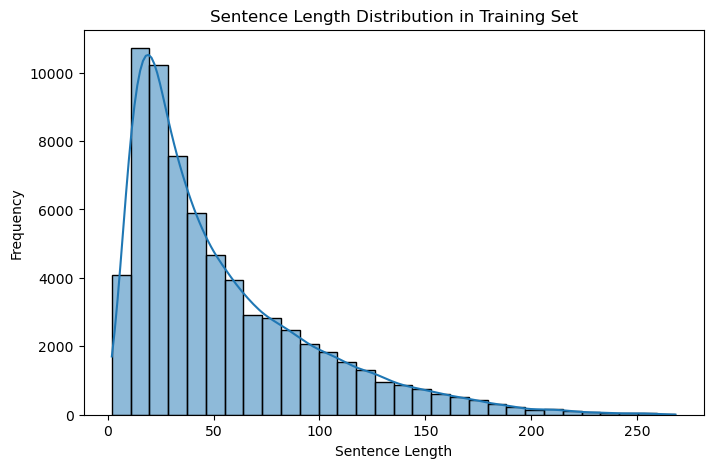

In [3]:
basic_statistics(df_train, "Training Set")

The training set has an average sentence length of 53.51 characters, with sentences ranging from 2 to **maximum 268 characters**. The distribution shows a right skew, indicating most sentences are short, but some are significantly longer.


Basic Statistics for Validation Set:
Average sentence length: 105.84
Max sentence length: 244
Min sentence length: 6


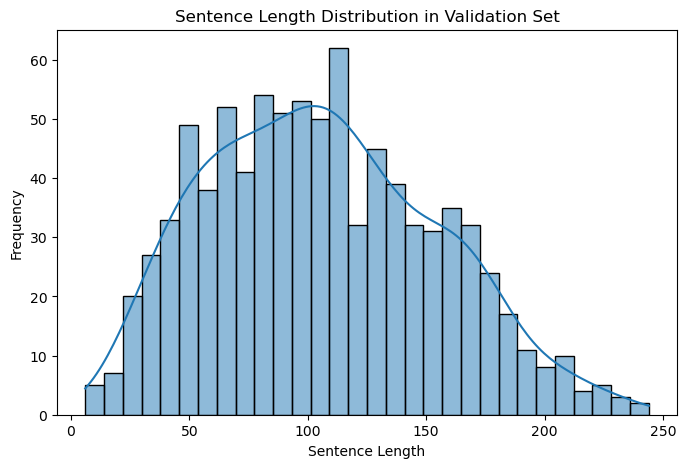

In [4]:
basic_statistics(df_val, "Validation Set")

The validation set has an average sentence length of 105.84 characters, with lengths ranging from 6 to **maximum 244 characters**. The distribution is fairly balanced and unimodal, centered around 100-110 characters.


Basic Statistics for Test Set:
Average sentence length: 102.96
Max sentence length: 256
Min sentence length: 6


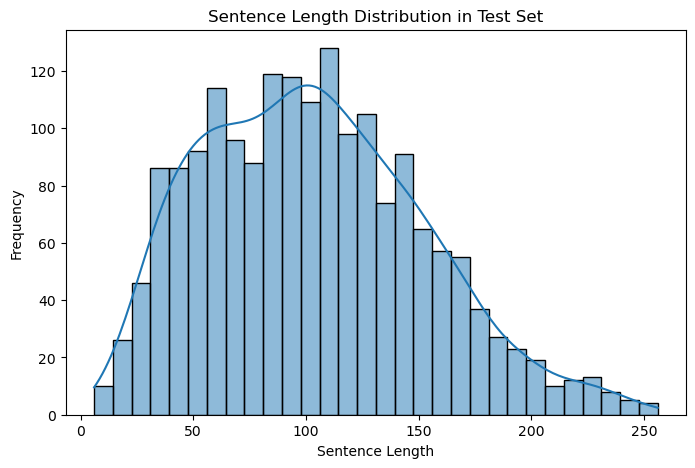

In [5]:
basic_statistics(df_test, "Test Set")

The test set has an average sentence length of 102.96 characters, ranging from 6 to **maximum 256 characters**. The distribution is unimodal and slightly right-skewed, with most sentences centered around 100-110 characters.

**Conclusion**:

It's interesting that the training, validation test sets show notable differences in sentence length distributions. The training set is heavily skewed toward shorter sentences (average: 53.51 characters), while the validation and test sets have more balanced, unimodal distributions (averages: 105.84 and 102.96 characters, respectively). This suggests the training set contains simpler or shorter text, whereas the validation and test sets likely include more complex or descriptive sentences. This discrepancy may require preprocessing adjustments or model fine-tuning to ensure consistent performance across datasets.

Maximum text lengths: 268 (train), 244 (validation), 256 (test)

### 1.2 Class Distribution


Class Distribution in Training Set:
Label 0: 29780 samples
Label 1: 37569 samples


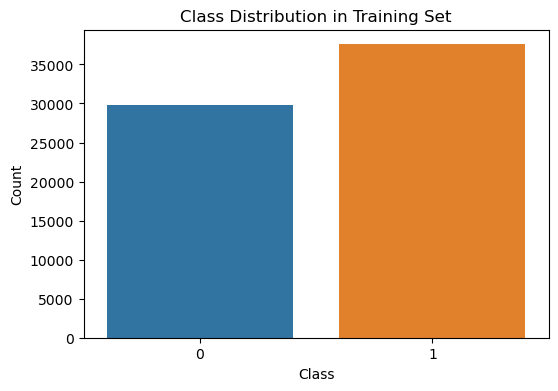

In [6]:
explore_class_distribution(df_train, "Training Set")

We can see a slight imbalance with Label 1 (positive) having more samples (37'569) than Label 0 (negative) (29'780).


Class Distribution in Validation Set:
Label 1: 444 samples
Label 0: 428 samples


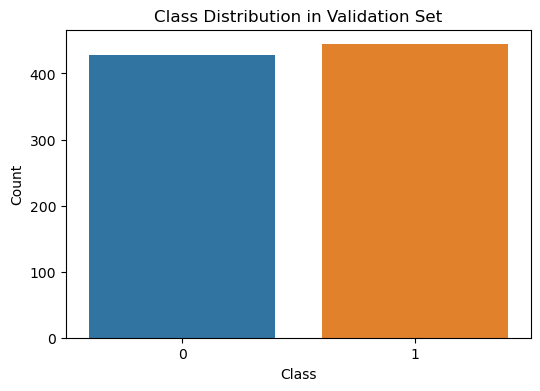

In [7]:
explore_class_distribution(df_val, "Validation Set")

There is a balanced distribution with almost equal samples for Label 1 (444) and Label 0 (428).


Class Distribution in Test Set:
Label -1: 1821 samples


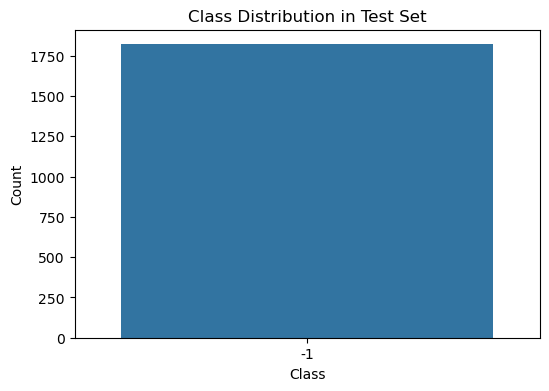

In [8]:
explore_class_distribution(df_test, "Test Set")

The test set only contains Label -1 (unlabeled) with 1'821 samples, because the task is to predict the sentiment of these unlabeled samples, therefore these samples are not labeled and masked as -1.

**Conclusion**:

The training set's slight class imbalance could affect model learning, favoring positive sentiment. The validation set is well-balanced, ensuring fair evaluation. The test set being entirely unlabeled suggests it will serve for prediction-only tasks or further labeling. Consistent evaluation metrics should account for these differences.

### 1.3 Word Length Distribution


Word Length Statistics for Training Set:
Average word count: 9.41
Max word count: 52
Min word count: 1


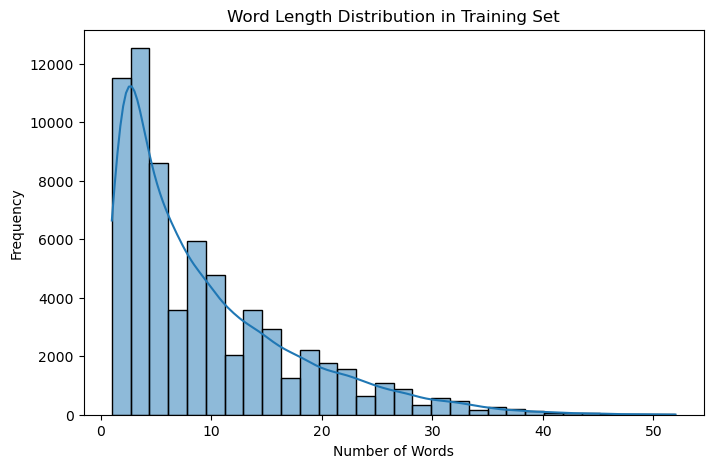

In [9]:
plot_word_length_distribution(df_train, "Training Set")

The average word count of the training set is 9.41, with sentences ranging from 1 to **maximum 52 words**. Distribution is heavily skewed toward shorter sentences (right skewed).


Word Length Statistics for Test Set:
Average word count: 19.23
Max word count: 56
Min word count: 2


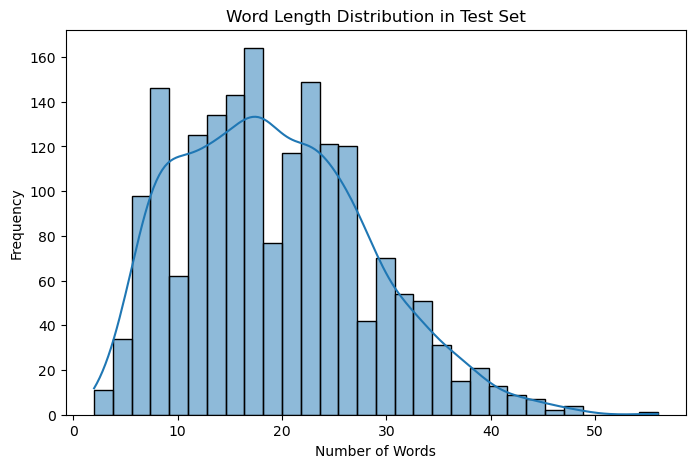

In [10]:
plot_word_length_distribution(df_test, "Test Set")

The average word count of the validation set is 19.23, with a range of 2 to **maximum 56 words**. Distribution is more balanced than the training set, centered around 20 words.


Word Length Statistics for Validation Set:
Average word count: 19.55
Max word count: 47
Min word count: 2


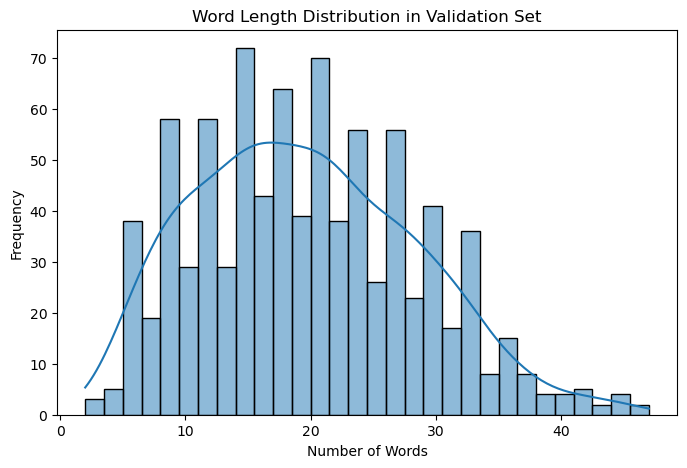

In [11]:
plot_word_length_distribution(df_val, "Validation Set")

The average word count of the test set is 19.55, with a range of 2 to **maximum 47 words**. Similar balanced distribution as the test set, centered around 20 words.

**Conclusion**:

The training set primarily contains shorter sentences, while the validation and test sets include longer, more complex sentences. This discrepancy indicates potential challenges for the model to generalize across datasets and highlights the need for preprocessing strategies or careful evaluation during training.

Maximum word counts: 52 (train), 56 (validation), 47 (test)

Here are some options to address these discrepancies:
- Data Augmentation
- Subsampling Validation and Test Data
- Adjust Tokenization Strategies
- Transfer Learning with Pre-trained Models
- Weighted Loss Function
- Evaluate with Length-Specific Metrics

After looking at the options above, we have decided to go for this approach:

1. Start with data augmentation to create longer sentences in the training set.
2. Fine-tune a pre-trained model like BERT while increasing the maximum token length during tokenization.
3. Length-based evaluation to assess performance on short, medium, and long sentences separately to identify and address potential issues.

### 1.4 Word Cloud

In this section we explore common words associated with positive and negative sentiments.

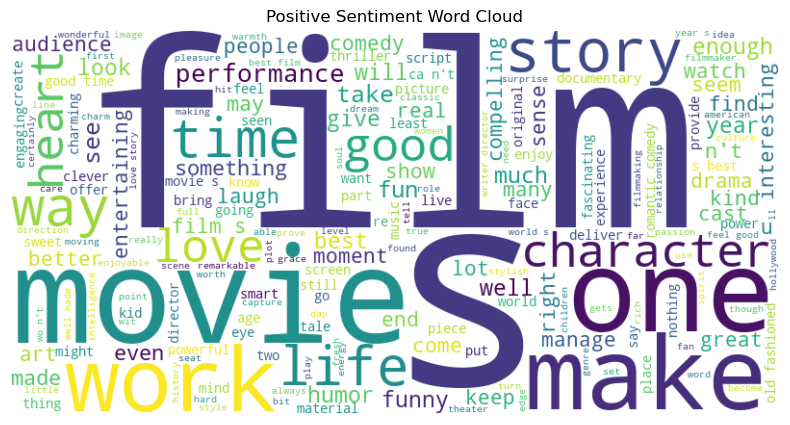

In [12]:
plot_word_cloud(df_train, sentiment_label=1, title="Positive Sentiment Word Cloud")

Here we can see some positive words such as "funny", "entertaining", "well", "love", "life", "good", "compelling", "interesting" and so on

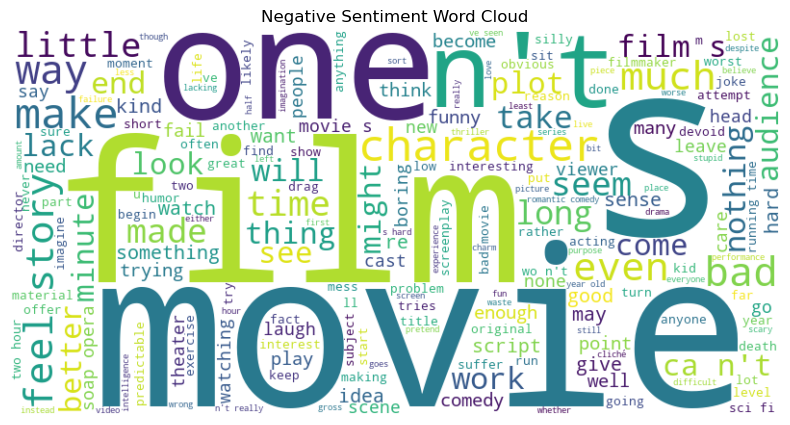

In [13]:
plot_word_cloud(df_train, sentiment_label=0, title="Negative Sentiment Word Cloud")

For the sentences that have negative sentiment, we can see words such as "little", "bad", fail", "lack", "trying", "boring" "n't" and so on.

### 1.5 Vocabulary Analysis

For the vocabulary analysis we want to understand the diversity of words and identify any unusual tokens.

Vocabulary size after advanced filtering: 13676
Top 10 common words: [('film', 4056), ('movie', 3730), ('n', 2328), ('one', 2129), ('like', 1827), ('good', 1501), ('story', 1403), ('funny', 1159), ('characters', 1136), ('comedy', 1103)]


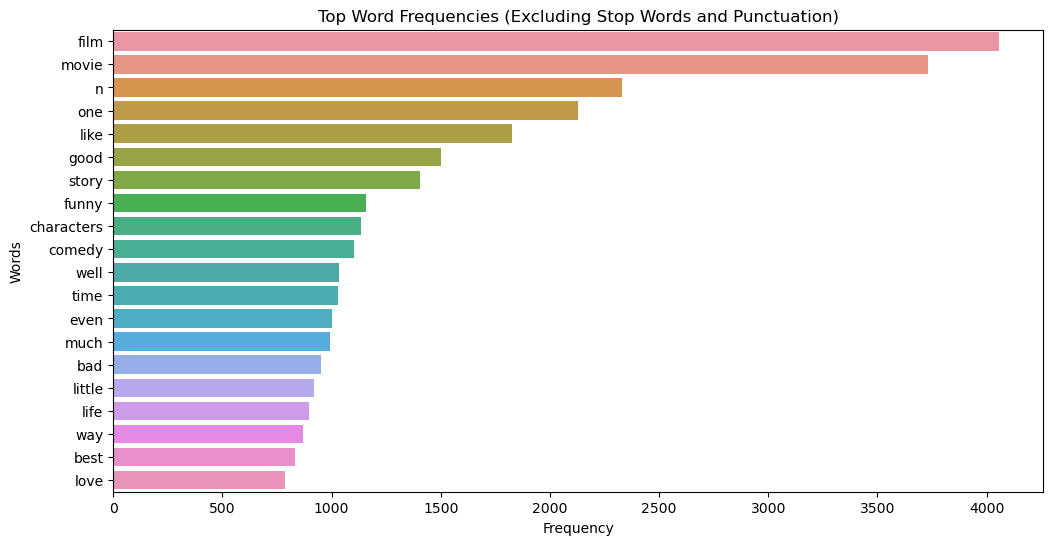

In [14]:
word_counts = analyze_vocabulary(df_train)
plot_word_frequency(word_counts)

## 2. Preprocess Data

### 2.1 Tokenize Texts

In [12]:
# Load Hugging Face tokenizer
tokenizer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Tokenize training, validation and test sets
train_tokens = tokenize_data(tokenizer, df_train)
val_tokens = tokenize_data(tokenizer, df_val)
test_tokens = tokenize_data(tokenizer, df_test)

### 2.2 Token Length Distribution


Token Length Statistics for Training Set:
Average token length: 13.32
Max token length: 66
Min token length: 3


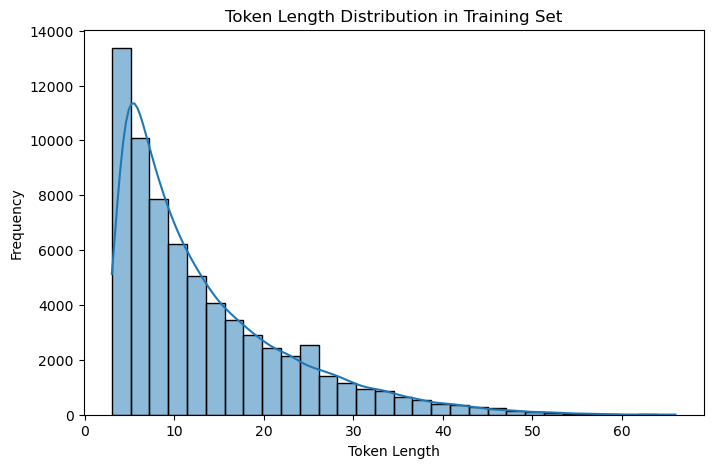

In [13]:
train_token_lengths = calculate_token_lengths(df_train, tokenizer, "Training Set")
plot_token_length_distribution(train_token_lengths, "Training Set")

The average token length of the sentences in the training set is 13.32, with a range of 3 to **maximum 66 tokens**. The distribution is skewed with most sentences having fewer tokens.


Token Length Statistics for Validation Set:
Average token length: 25.16
Max token length: 55
Min token length: 4


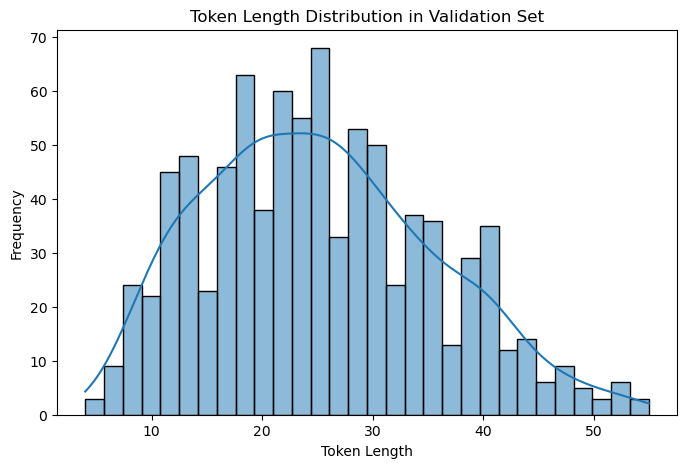

In [14]:
val_tokens_lengths = calculate_token_lengths(df_val, tokenizer, "Validation Set")
plot_token_length_distribution(val_tokens_lengths, "Validation Set")

The average token length of the sentences in the validation set is 25.16, ranging from 4 to **maximum 55 tokens** and there is a more balanced distribution, centered around 20–30 tokens.


Token Length Statistics for Test Set:
Average token length: 24.86
Max token length: 64
Min token length: 4


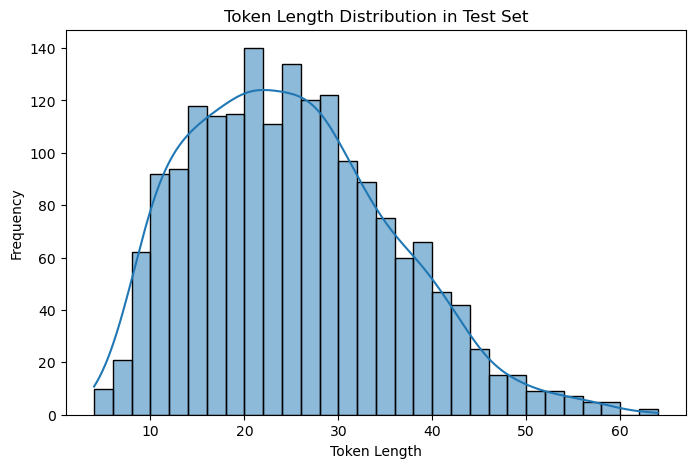

In [15]:
test_tokens_lengths = calculate_token_lengths(df_test, tokenizer, "Test Set")
plot_token_length_distribution(test_tokens_lengths, "Test Set")

The average token length of the sentences in the test set is 24.86, with a range of 4 to **maximum 64 tokens**. Similar balanced distribution to the validation set.

**Conclusion**:

The training set contains significantly shorter tokenized sequences compared to the validation and test sets. This mismatch may hinder the model's generalization. Adjusting tokenization strategies (for example increasing `max_length`) or augmenting the training set with synthetically lengthened sequences could help bridge the gap.

Maximum token counts: 66 (train), 55 (validation), 64 (test)

### 2.3 Balance Training Set

In [16]:
df_train_balanced = balance_dataset_undersample(df_train)

Class distribution after undersampling:
0    29780
1    29780
Name: label, dtype: int64


### 2.3 Nested Data Splits

Below we define **nested data splits** with `split_sizes = [0.01, 0.1, 0.3, 0.5, 0.75, 1.0]` to create incrementally larger training subsets from `df_train`. Larger splits contain all the samples from smaller splits. This approach benefits our use case by:

1. **Analyzing Learning Curves**: By training models on these splits, we can observe how performance scales as more labeled data is included, identifying the point of diminishing returns.

2. **Optimizing Labeling Effort**: Small splits simulate scenarios with limited labeled data. This helps determine how much data is needed for effective model training, saving annotation time and cost.
      
3. **Ensuring Consistency**: Nested splits prevent variability from random sampling by ensuring smaller datasets are strict subsets of larger ones, making results reliable and comparable.

By saving these splits as `.csv` files, we ensure reproducibility and streamline experiments to evaluate the impact of training data size on our model's performance.

In [17]:
split_sizes = [0.01, 0.1, 0.3, 0.5, 0.75, 1.0]
nested_splits = create_nested_splits(df_train_balanced, split_sizes)

# Save nested splits for reproducibility
for split_name, split_data in nested_splits.items():
    split_data.to_csv(f"{data_folder}train_split_{split_name}.csv", index=False)
    print(f"Saved nested split {split_name} to train_split_{split_name}.csv")

Created split: 1% with 595 samples.
Created split: 10% with 5956 samples.
Created split: 30% with 17868 samples.
Created split: 50% with 29780 samples.
Created split: 75% with 44670 samples.
Created split: 100% with 59560 samples.
Saved nested split 1% to train_split_1%.csv
Saved nested split 10% to train_split_10%.csv
Saved nested split 30% to train_split_30%.csv
Saved nested split 50% to train_split_50%.csv
Saved nested split 75% to train_split_75%.csv
Saved nested split 100% to train_split_100%.csv
